## Supervised Linear Regression (II)

In [335]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math 

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import sklearn.metrics as metrics

from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import kurtosis, skew

import seaborn as sns

%matplotlib inline



In [336]:
#load football_clean_supervised dataset
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df
df_football= load_dataset('cleaned_files/football_clean_supervised.csv')

In [337]:
# df_football.head(3)
# df_football.columns
# print (sum(df_football['STARCOLL'] == df_football['institution_name_short'])) #these columns match 1263 

#save athlete names for later indexing
athlete_names = df_football['NAME']
# athlete_names




In [338]:
#remove Unnamed:0, Name, STARCOLL,  institution_short_name (same as STARCOLL),  EXP YEARS, and Sport column- not necessary 

def drop_col(df):
    df=df.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','institution_name_short', 'EXP_YEARS'])
    return df

df_football = drop_col(df_football).copy()

In [339]:
df_football.head(3)
# df_football.columns
# df_football.isna().sum()  #No missing values in data features

,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,TOT_FOL,RECRUIT_YEAR,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN
0,2.0,18.28281,99.53,18.0,1.0,75.5,220.0,459.0,2900000.0,73900.0,65000.0,8900.0,73900.0,2023.0,2.0,1.0,161532860.0,50633156.0
1,2.0,18.00000,97.87,25.0,8.0,73.5,225.0,207.0,497000.0,13100.0,13100.0,0.0,13100.0,2023.0,2.0,1.0,161532860.0,50633156.0
2,2.0,18.00000,97.26,25.0,9.0,73.0,216.0,992.0,443000.0,10900.0,9200.0,1700.0,10900.0,2023.0,2.0,1.0,161532860.0,50633156.0


**EDA of football dataset**

In [340]:
# df_football.corr()

In [341]:
#Correlation 
def correlation_summary(df):
    # return df.corr()
    corr_matrix = df.corr()
    return print(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False)[:20])

correlation_summary(df_football)

NILVAL_LONG_USD       1.000000
INSTA_LONG            0.402525
TOT_FOL               0.402525
ClassificationCode    0.376254
TIK_LONG              0.359623
TWIT_LONG             0.320731
SKILL                 0.252480
GRADE                 0.172487
EXP_MONTHS            0.111587
AGE                   0.109558
NUMOFF                0.069421
REV_MEN               0.020426
COLLDIST_MI           0.013713
HEIGHT_IN            -0.015442
EXP_MEN              -0.035130
WEIGHT_LBS           -0.045649
RECRUIT_YEAR         -0.114316
POS                  -0.133718
Name: NILVAL_LONG_USD, dtype: float64


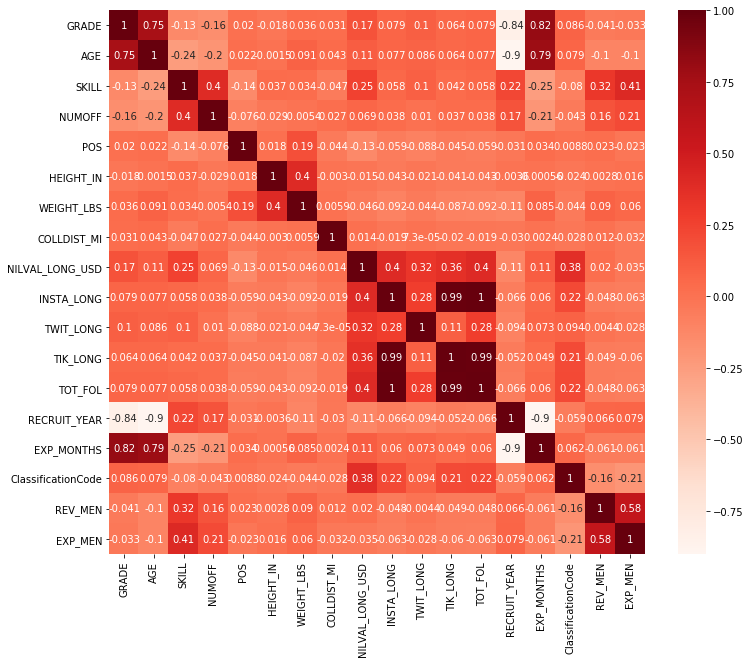

In [342]:

plt.figure(figsize=(12,10))
cor = df_football.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

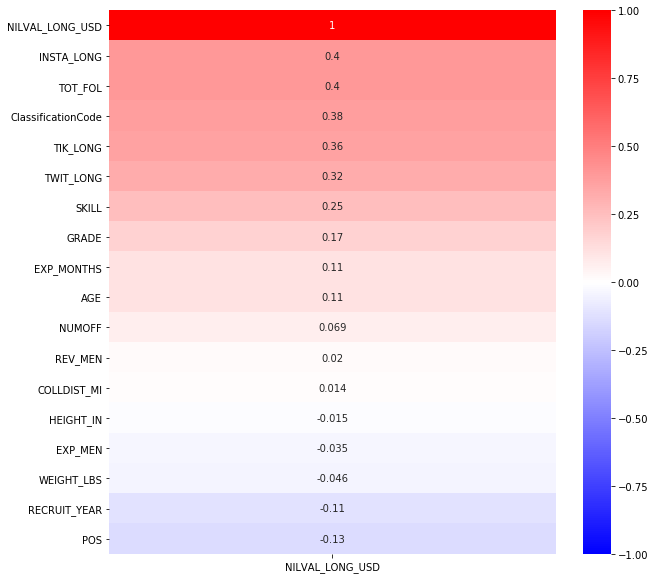

In [343]:
#Correlation heatmap
#https://stackoverflow.com/questions/72213733/how-to-plot-seaborn-heatmap-for-target-vs-independent-features
#+1= highly and positively correlated and -1 = highly negatively correlated.
def corr_plot(df):
    corr_matrix = df.corr()
    data=pd.DataFrame(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False))  #plotting all but could do top (>.50)
    plt.figure(figsize = (10,10))
    return  sns.heatmap(data, annot=True, vmin=-1, vmax=1, cmap='bwr')
    # ax.tick_params(labelrotation=0)

fb_corr_heat=corr_plot(df_football)

In [344]:
#Correlation with output variable
cor_target = abs(cor["NILVAL_LONG_USD"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.20]
relevant_features

SKILL                 0.252480
NILVAL_LONG_USD       1.000000
INSTA_LONG            0.402525
TWIT_LONG             0.320731
TIK_LONG              0.359623
TOT_FOL               0.402525
ClassificationCode    0.376254
Name: NILVAL_LONG_USD, dtype: float64

**Using CUSTOM TRAIN VALID SPLIT**

In [345]:
# # Since our pipeline is not up and running yet, let's just import the traintestsplit function
# from python_scripts.traintestsplit import custom_train_test_split

In [346]:
# X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_football)

# print (X_train_fb.shape,y_train_fb.shape )
# print (X_valid_fb.shape, y_valid_fb.shape)
# print (X_test_fb.shape, y_test_fb.shape)

In [347]:

def custom_train_test_split(df, train_size_=0.70, valid_size_=0.15, test_size_=0.15,RANDOM_STATE=0):
    """
    :: Input(s) ::
        df - a dataframe containing all of the features and the target feature
        valid_size - the subset of the remaining training set after the test set was formed
        test_size - the size ofthe validation when compared to the training set
        RANDOM_STATE - a random state for this function to promote repeatability
    :: Output(s) ::
        X_train - training feature dataframe
        X_valid - validation feature dataframe
        X_test - testing feature dataframe
        y_train - training target feature
        y_valid - validation target feature
        y_test - testing target feature
    :: Function Description ::
        'custom_train_test_split' looks to take a cleaned dataframe and split it into the various training, validating, and testing datasets.
    """
    # Transform the continuous "SKILL_" column into a categorical such that it could be binned
    # bins = [0, 80, 85, 90, 95, 100]
    # labels = [
    #     "Very Low Skill",
    #     "Low Skill",
    #     "Medium Skill",
    #     "High Skill",
    #     "Very High Skill",
    # ]
    # df = df.copy()
    # df["SKILL_CAT"] = pd.cut(df["SKILL"], bins=bins, labels=labels).astype(str)

    
    bins =  4
    df['SKILL_CAT'] = pd.cut(df['SKILL'],bins=bins,labels=False)

    # Shuffle the dataframe
    df = df.sample(frac=1, random_state=RANDOM_STATE)

    # Get our X and y arrays/ Target Feature: NILVAL_LONG_USD

    y = df.pop("NILVAL_LONG_USD")
    y= np.log1p(y)
    X = df



#Produce train 70% / rest 30% (validation  & test)
    X_train, X_remaining, y_train, y_remaining,  = train_test_split(
        X,
        y,
        test_size = (1-train_size_),
          stratify=X["SKILL_CAT"],
        random_state=RANDOM_STATE,
    )



# NEW -Split remaining 30% by 0.5 to get 15% each validation and test
    rel_test_size_= test_size_ / (valid_size_ + test_size_)

    X_valid, X_test, y_valid, y_test = train_test_split(
        X_remaining,
        y_remaining,
        test_size= rel_test_size_,
        stratify=X_remaining["SKILL_CAT"],
        random_state=RANDOM_STATE,
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [348]:
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_football, train_size_=0.70, valid_size_=0.15, test_size_=0.15)

print (X_train_fb.shape,y_train_fb.shape )
print (X_valid_fb.shape, y_valid_fb.shape)
print (X_test_fb.shape, y_test_fb.shape)

(884, 18) (884,)
(189, 18) (189,)
(190, 18) (190,)


**Dummy Regressor- All Features**

In [349]:
def dummy_reg(X_train,y_train,X_test,y_test):
    #create Dummy Regressor, fit
    mean_dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)

    #make predictions
    y_pred = mean_dummy.predict(X_test)

    #metrics calculations
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2

In [350]:
mse_fb, rmse_fb, r2_fb = dummy_reg(X_train_fb,y_train_fb,X_test_fb,y_test_fb)
print("Mean squared error (dummy): {:.4f}, RMSE (dummy): {:.4f}; r2_score (dummy): {:.4f}".format(mse_fb, rmse_fb,r2_fb))

Mean squared error (dummy): 0.3728, RMSE (dummy): 0.6105; r2_score (dummy): -0.0002


**Linear Regression model- No Scaling, All Features**

In [351]:
def linear_reg(X_train, y_train, X_valid, X_test):
     #Create an instance of the LinearRegression model
    model = LinearRegression()

    #Train the model on the training set
    model.fit(X_train, y_train)
   
     # Make predictions on the train set
    y_train_pred = model.predict(X_train)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_valid)

    #Make predictions on the test set
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_val_pred, y_test_pred

    

In [352]:
y_train_pred_fb, y_val_pred_fb, y_test_pred_fb = linear_reg(X_train_fb, y_train_fb, X_valid_fb, X_test_fb)

In [353]:
#regression results

#https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does
def regression_results(str,y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
  

    print('{} explained_variance: '.format (str), round(explained_variance,4))    
    # print('{} mean_squared_log_error: '.format(str), round(mean_squared_log_error,4))
    print('{} r2: '.format (str), round(r2,4))
    print('{} MAE: '.format(str), round(mean_absolute_error,4))
    print('{} MSE: '.format (str), round(mse,4))
    print('{} RMSE: '.format (str), round(np.sqrt(mse),4))


    # # Calculate and print performance metrics for the validation set
regression_results("Training", y_train_fb, y_train_pred_fb)

    # # Calculate and print performance metrics for the validation set
regression_results("Validation", y_valid_fb, y_val_pred_fb)

# Calculate and print performance metrics for the test set
regression_results('Testing', y_test_fb, y_test_pred_fb)

Training explained_variance:  0.3535
Training r2:  0.3535
Training MAE:  0.3618
Training MSE:  0.2464
Training RMSE:  0.4964
Validation explained_variance:  0.2464
Validation r2:  0.2272
Validation MAE:  0.3406
Validation MSE:  0.2315
Validation RMSE:  0.4812
Testing explained_variance:  0.3594
Testing r2:  0.3522
Testing MAE:  0.3372
Testing MSE:  0.2414
Testing RMSE:  0.4914


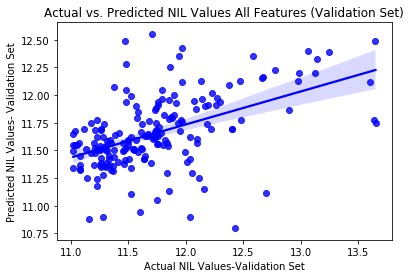

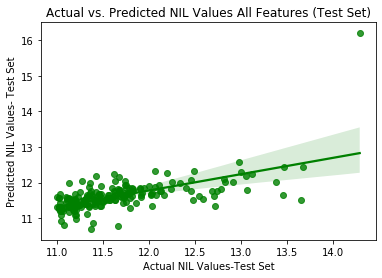

In [354]:
# Visualize the results (scatter plot of actual vs. predicted values for the validation set)
sns.regplot(x=y_valid_fb, y=y_val_pred_fb,color = 'blue')
plt.xlabel("Actual NIL Values-Validation Set")
plt.ylabel("Predicted NIL Values- Validation Set")
plt.title("Actual vs. Predicted NIL Values All Features (Validation Set)")
plt.show()

# Visualize the results (scatter plot of actual vs. predicted values for the test set)

sns.regplot(x=y_test_fb, y=y_test_pred_fb,color = 'green')
plt.xlabel("Actual NIL Values-Test Set")
plt.ylabel("Predicted NIL Values- Test Set")
plt.title("Actual vs. Predicted NIL Values All Features (Test Set)")
plt.show()

**Comparing single Train/Valid/Test Split  to Cross Validation**

In [363]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

df_football2 = df_football.copy()


y = df_football2.pop("NILVAL_LONG_USD")
y = np.log1p(y)
X= df_football2.values  #convert to np array
k=5

model = LinearRegression()
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

mse_scores = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

print(f"Mean MSE: {np.mean(mse_scores)}")


Mean MSE: 0.35298246808597283


**Linear Regresssion with Standardization**

In [356]:
def lreg_standard(X_train,y_train,X_valid, X_test):
    #Initialize the scaler
    scaler = StandardScaler()

    # Fit_transform  scaler on training, validation, test data 
    X_train_scaled = scaler.fit_transform(X_train) #For training data
    X_valid_scaled = scaler.transform(X_valid)  # For validation data
    X_test_scaled = scaler.transform(X_test)    # For test data

    #Create an instance of the LinearRegression model
    model = LinearRegression()

    #Train the model on the training set
    model.fit(X_train_scaled, y_train)
    
     # Make predictions on the train set
    y_train_pred = model.predict(X_train_scaled)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_valid_scaled)

    #Make predictions on the test set
    y_test_pred = model.predict(X_test_scaled)

    return y_train_pred, y_val_pred, y_test_pred

In [357]:
y_train_pred_fb, y_val_pred_fb, y_test_pred_fb = lreg_standard(X_train_fb, y_train_fb, X_valid_fb, X_test_fb)
# Calculate and print performance metrics for the validation set
regression_results("Training", y_train_fb, y_train_pred_fb)

# Calculate and print performance metrics for the validation set
# regression_results("Validation", y_valid_fb, y_val_pred_fb)

# Calculate and print performance metrics for the test set
regression_results('Testing', y_test_fb, y_test_pred_fb)

Training explained_variance:  0.3535
Training r2:  0.3535
Training MAE:  0.3618
Training MSE:  0.2464
Training RMSE:  0.4964
Testing explained_variance:  0.3594
Testing r2:  0.3522
Testing MAE:  0.3372
Testing MSE:  0.2414
Testing RMSE:  0.4914


**Linear Regression with MinMax Scaler**

In [358]:
def lreg_minmax(X_train,y_train,X_valid, X_test):
   # Initialize the scaler
   scaler = MinMaxScaler()

    # Fit_transform  scaler on training, validation, test data 
   X_train_scaled = scaler.fit_transform(X_train) #For training data
   X_valid_scaled = scaler.transform(X_valid)  # For validation data
   X_test_scaled = scaler.transform(X_test)    # For test data

    #Create an instance of the LinearRegression model
   model = LinearRegression()

    #Train the model on the training set
   model.fit(X_train_scaled, y_train)

    #Make predictions
   y_train_pred = model.predict(X_train_scaled)

   y_val_pred = model.predict(X_valid_scaled)

   y_test_pred = model.predict(X_test_scaled)

   return y_train_pred, y_val_pred, y_test_pred

In [364]:
y_train_pred_fb, y_val_pred_fb, y_test_pred_fb = lreg_minmax(X_train_fb, y_train_fb, X_valid_fb, X_test_fb)

# Calculate and print performance metrics for the train set
regression_results("Training", y_train_fb, y_train_pred_fb)

# # Calculate and print performance metrics for the validation set
# regression_results("Validation", y_valid_fb, y_val_pred_fb)

# Calculate and print performance metrics for the test set
regression_results('Testing', y_test_fb, y_test_pred_fb)

Training explained_variance:  0.3535
Training r2:  0.3535
Training MAE:  0.3618
Training MSE:  0.2464
Training RMSE:  0.4964
Validation explained_variance:  0.2464
Validation r2:  0.2272
Validation MAE:  0.3406
Validation MSE:  0.2315
Validation RMSE:  0.4812
Testing explained_variance:  0.3594
Testing r2:  0.3522
Testing MAE:  0.3372
Testing MSE:  0.2414
Testing RMSE:  0.4914


**Lasso Regression**

**Polynomial Regression**

In [360]:
#Using output of custom_train_split
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_football)


In [361]:

from sklearn.preprocessing import PolynomialFeatures

#Using output of custom_train_split
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_football)

print (X_train_fb.shape,y_train_fb.shape )
print (X_valid_fb.shape, y_valid_fb.shape)
print (X_test_fb.shape, y_test_fb.shape)

# Choose the degree of the polynomial (e.g., 2 for quadratic regression)
degree = 2
poly = PolynomialFeatures(degree=degree)

X_train_poly = poly.fit_transform(X_train_fb)
X_valid_poly = poly.transform(X_valid_fb)
X_test_poly = poly.transform(X_test_fb)

#fit polynomial linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train_fb)

# Make predictions on the validation set
y_valid_pred = model.predict(X_valid_poly)

# Calculate the Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(y_valid_fb, y_valid_pred)
print(f"Mean Squared Error on Validation Set: {mse}")

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_valid_fb, y_valid_pred))
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")

# Calculate the R-squared (R2) score
r2 = r2_score(y_valid_fb, y_valid_pred)
print(f"R-squared (R2) Score on Validation Set: {r2}")

# # Make predictions on the test set
# y_test_pred = model.predict(X_test_poly)

# Calculate the Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(y_test_fb, y_test_pred)
print(f"Mean Squared Error on Test Set: {mse}")

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test_fb, y_test_pred))
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse}")

# Calculate the R-squared (R2) score
r2 = r2_score(y_test_fb, y_test_pred)
print(f"R-squared (R2) Score on Test Set: {r2}")



# # Plot the actual vs. predicted values on the test sequence
# plt.scatter(X_test_fb, y_test_fb, label='Actual Data')
# plt.plot(X_test_sequence, y_test_sequence_pred, label='Polynomial Regression', color='red')
# plt.xlabel('X_test')
# plt.ylabel('y_test')
# plt.title('Polynomial Linear Regression')
# plt.legend()
# plt.show()


(884, 18) (884,)
(189, 18) (189,)
(190, 18) (190,)
Mean Squared Error on Validation Set: 0.17848196365736496
Root Mean Squared Error (RMSE) on Validation Set: 0.42247125778846184
R-squared (R2) Score on Validation Set: 0.404221089629758
Mean Squared Error on Test Set: 33724429698.77055
Root Mean Squared Error (RMSE) on Test Set: 183642.1239769638
R-squared (R2) Score on Test Set: -90491232016.0441


In [365]:
# #apply simple linear regression
# lrpoly = LinearRegression()
# lrpoly.fit(X_train_fbtrans, y_train_fb)
# y_pred_fb = lrpoly.predict(X_test_fbtrans)
# print(r2_score(y_test_fb, y_pred_fb))

**Using selected features**

In [366]:
#use these features only
columns = ['SKILL','INSTA_LONG','TWIT_LONG','TIK_LONG','TOT_FOL','ClassificationCode','NILVAL_LONG_USD']
df_fb2= df_football[columns].copy()

#custom train-valid-test split

X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb =custom_train_test_split (df_fb2)
print (X_train_fb.shape,y_train_fb.shape )
print (X_valid_fb.shape, y_valid_fb.shape)
print (X_test_fb.shape, y_test_fb.shape)

(884, 7) (884,)
(189, 7) (189,)
(190, 7) (190,)


In [367]:
def dummy_reg(X_train,y_train,X_test,y_test):
    #create Dummy Regressor, fit
    mean_dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)

    #make predictions
    y_pred = mean_dummy.predict(X_test)

    #metrics calculations
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2
mse_fb, rmse_fb, r2_fb = dummy_reg(X_train_fb,y_train_fb,X_test_fb,y_test_fb)
print("Mean squared error (dummy): {:.4f}, RMSE (dummy): {:.4f}; r2_score (dummy): {:.4f}".format(mse_fb, rmse_fb,r2_fb))

Mean squared error (dummy): 0.3728, RMSE (dummy): 0.6105; r2_score (dummy): -0.0002


In [368]:
#Linear Regression - Selected features
y_train_pred_fb, y_val_pred_fb, y_test_pred_fb = linear_reg(X_train_fb, y_train_fb, X_valid_fb, X_test_fb)
    # # Calculate and print performance metrics for the validation set
regression_results("Training", y_train_fb, y_train_pred_fb)

#     # # Calculate and print performance metrics for the validation set
# regression_results("Validation", y_valid_fb, y_val_pred_fb)

# Calculate and print performance metrics for the test set
regression_results('Testing', y_test_fb, y_test_pred_fb)

Training explained_variance:  0.3035
Training r2:  0.3035
Training MAE:  0.375
Training MSE:  0.2655
Training RMSE:  0.5153
Testing explained_variance:  0.2925
Testing r2:  0.291
Testing MAE:  0.3486
Testing MSE:  0.2642
Testing RMSE:  0.514


In [ ]:

lin_lasso(X_train_fb, X_valid_fb, X_test_fb, y_train_fb, y_test_fb)